# Ilarduia (C068)

#### Euskalmeten Ilarduiako estazioko datuen irudikatzea.

### Under construction . . . 💻🛠️

In [99]:
# Data handling:
import numpy as np
import pandas as pd

# Data representation:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Lehenik eta behin, kargatu datuak (_download_station_readings.ipynb_ skriptarekin lortuak).

In [2]:
# Load table with station readings:
fpath = "../data/readings_C068.csv"
df = pd.read_csv(fpath, sep = ",")

Moldatu taula gure beharretara:

In [3]:
# Remove lines with no readings:
var_nms = ["temperature", "humidity", "direction_sigma", "mean_speed", "mean_direction", "speed_sigma", "max_speed", "precipitation"]
df.dropna(subset = var_nms, how = "all", inplace = True)

# Create a column of type datetime:
df['timestamp'] = df['YYYY'].astype(str) + "-" + df['MM'].astype(str) + '-' + df['DD'].astype(str) + "T" + df['hh'].astype(str) + ":" + df['mm'].astype(str) + ":0"
df['timestamp'] = pd.to_datetime(df['timestamp'], format = "%Y-%m-%dT%H:%M:%S", utc = True)


In [95]:
### Summarise dataframe as hourly averages/sums:
daily = df.groupby(['YYYY', 'MM', 'DD']).agg(temperature_mean = ('temperature', 'mean'),
                                             temperature_min = ('temperature', 'min'),
                                             temperature_max = ('temperature', 'max'),
                                             humidity_mean = ('humidity', 'mean'),
                                             humidity_min = ('humidity', 'min'),
                                             humidity_max = ('humidity', 'max'),
                                             direction_sigma_mean = ('direction_sigma', 'mean'),
                                             mean_speed_mean = ('mean_speed', 'mean'),
                                             mean_direction_mean = ('mean_direction', 'mean'),
                                             speed_sigma_mean = ('speed_sigma', 'mean'),
                                             max_speed_mean = ('max_speed', 'mean'),
                                             max_speed_max = ('max_speed', 'max'),
                                             precipitation_sum = ('precipitation', 'sum'),
                                             timestamp = ('timestamp', 'min')
                                            )
# When grouping and aggregating, the grouping variables are set as indexes, but I want to keep them as variables:
daily.reset_index(names = ['YYYY', 'MM', 'DD'], inplace = True)

# Add column representing the day of the year for each date (1-365)
daily['day_of_year'] = daily['timestamp'].dt.dayofyear

# Create a dummy datetime format column so that we map these days_of_year into datetime class, 
# setting an equal random year for all -> it can be useful to set readable axis labels when plotting:
daily['day_of_year_dt'] = pd.to_datetime(2023 * 1000 + daily['day_of_year'], format='%Y%j')

# Add column describing whether datapoints belong to the last year in the dataset or not:
daily['is_last_year'] = np.where(daily['YYYY'] == max(daily['YYYY']), True, False) 


### Summarise dataframe as monthly averages/sums:
# monthly = df.groupby(['YYYY', 'MM']).agg(temperature_mean = ('temperature', 'mean'),
#                                        temperature_min = ('temperature', 'min'),
#                                        temperature_max = ('temperature', 'max'),
#                                        humidity_mean = ('humidity', 'mean'),
#                                        humidity_min = ('humidity', 'min'),
#                                        humidity_max = ('humidity', 'max'),
#                                        direction_sigma_mean = ('direction_sigma', 'mean'),
#                                        mean_speed_mean = ('mean_speed', 'mean'),
#                                        mean_direction_mean = ('mean_direction', 'mean'),
#                                        speed_sigma_mean = ('speed_sigma', 'mean'),
#                                        max_speed_mean = ('max_speed', 'mean'),
#                                        max_speed_max = ('max_speed', 'max'),
#                                        precipitation_sum = ('precipitation', 'sum'),
#                                        timestamp = ('timestamp', 'min')
#                                       )
# monthly

# Estimate monthly climatologies:


### Datuen irudikatzea

Plot daily average temperatures over the entire dataset:

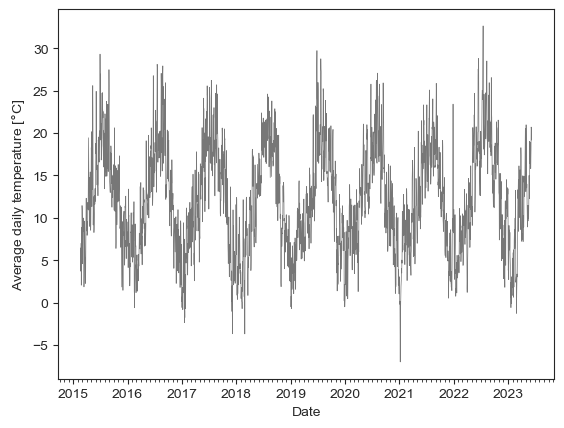

In [111]:
with sns.axes_style("ticks"):
    ts_temp = sns.lineplot(data=daily,
                           x="timestamp", y="temperature_mean",
                           linewidth = .5, c = "#777777")
    ts_temp.set(xlabel = "Date", ylabel = "Average daily temperature [$\degree$C]")
    ts_temp.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
    ts_temp.xaxis.set_minor_locator(mdates.MonthLocator())
    ts_temp.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.show(ts_temp)

We can also visualise the annual temperature cycle by plotting the dataset by day of year:

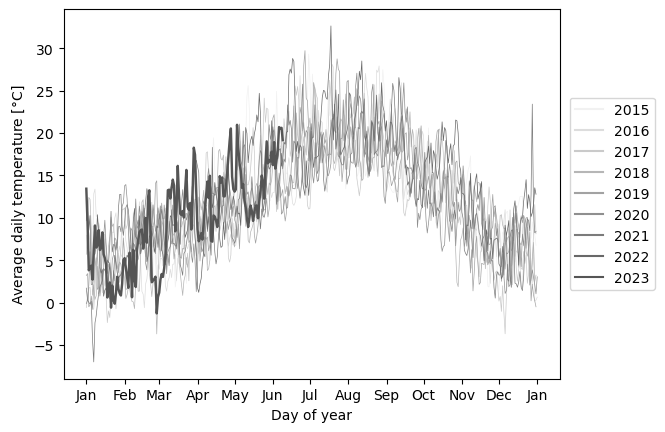

In [108]:
pal = sns.light_palette("#555555", n_colors=len(set(daily['YYYY']))) 
lp_temp = sns.lineplot(data = daily,
                       x = "day_of_year_dt", y = "temperature_mean",
                       hue="YYYY", palette = pal,
                       size = "is_last_year", sizes = (.5,1.75), size_order = [True, False])
lp_temp.set(xlabel = "Day of year", ylabel = "Average daily temperature [$\degree$C]")
lp_temp.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
lp_temp.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
h,l = lp_temp.get_legend_handles_labels()
plt.legend(h[1:10], l[1:10], bbox_to_anchor = (1.02, .5), loc = "center left", ncol = 1, title = None, borderaxespad = 0)
plt.show(lp_temp)

# Note to self: apparently the "subtitles" of the different parts of the legends (say, hue and size here) 
# can be removed/customised by treating them as labels (I mean, I guess because they are technically labels due to how seaborn handles them? idk)
# So, for instance, by not selecting the index=0 I remove the 'YYYY' heading for the hue legend

We can aid visualisation by plotting the daily average temperature along with the standard deviation:

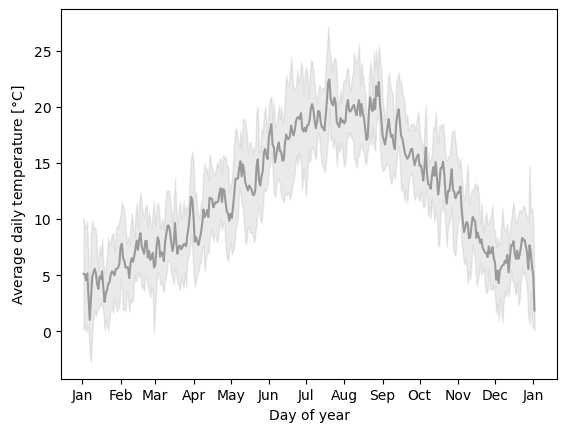

In [109]:
lp_temp_av = sns.lineplot(x = "day_of_year", y = "temperature_mean",
                          data = daily,
                          c = "#999999",
                          estimator = "mean",
                          errorbar = "sd")
lp_temp_av.set(xlabel = "Day of year", ylabel = "Average daily temperature [$\degree$C]")
lp_temp_av.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
lp_temp_av.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(lp_temp_av)

We could superimpose the data from the current year to see how it compares to the dataset average:

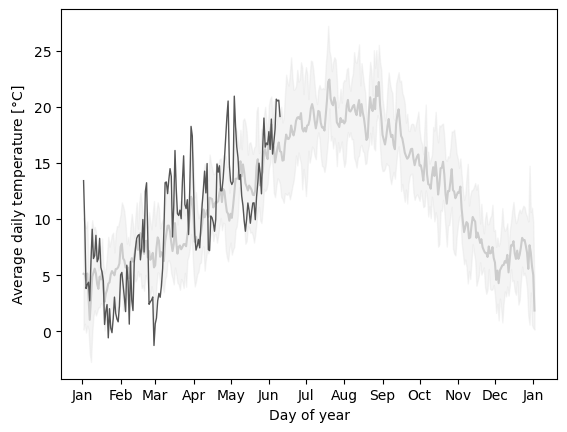

In [110]:
fig_temp_av, ax_temp_av = plt.subplots()
sns.lineplot(x="day_of_year", y="temperature_mean",
             data=daily,
             c = "#cccccc",
             estimator = "mean",
             errorbar = "sd",
             ax = ax_temp_av)
sns.lineplot(x="day_of_year", y="temperature_mean",
             data=daily[daily['is_last_year']],
             c = "#555555",
             linewidth = 1,
             estimator = None,
             ax = ax_temp_av)
ax_temp_av.set(xlabel = "Day of year", ylabel = "Average daily temperature [$\degree$C]")
ax_temp_av.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
ax_temp_av.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(ax_temp_av)

### Irradiance

##### This station has no irradiance data but, if we had it, we could estimate some useful parameters:

[According to WMO (2010)](https://library.wmo.int/doc_num.php?explnum_id=3154), sunshine duration during a given period is defined as the sum of the time for which the direct solar irradiance exceeds 120 W·m<sup>-2</sup>.

Maximum possible sunshine duration (N) depends on the latitude of the site and the solar declination angle, and can be estimated with the following [expression](https://doi.org/10.1016/j.rser.2015.05.068):

$$ N = {2\over15}\times arccos(−tan(\varphi) \times tan(\delta)) $$

where $\varphi$ is the latitude of the site under consideration (in the range of −90 ≤ $\varphi$ ≤ +90) and $\delta$ is the solar declination given by the following expression:

$$ \delta = 23.4 \times \sin({360\over365}\times(284 + d)) $$

where ___d___ is the day of the year, starting from _1_ for January 1<sup>st</sup>.
